## Name and ID

Mattia Danese

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](piazza.com/tufts/spring2021/comp135/home).

### Import required libraries

In [81]:
import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

Complete the following code.

In [82]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(len(ytrue_N)):
        if ytrue_N[i] == 1 and yhat_N[i] == 1:
            TP += 1
        elif ytrue_N[i] == 0 and yhat_N[i] == 0:
            TN += 1
        elif ytrue_N[i] == 0 and yhat_N[i] == 1:
            FP += 1
        else:
            FN += 1
    
    return TP, TN, FP, FN

In [83]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [84]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [85]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [86]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [87]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [88]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [89]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [90]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [91]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [92]:
print("Fraction with cancer in TRAIN: %.3f" % (np.sum(y_tr_M) / len(y_tr_M))) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: %.3f" % (np.sum(y_va_N) / len(y_va_N)))
print("Fraction with cancer in TEST : %.3f" % (np.sum(y_te_N) / len(y_te_N)))



Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [93]:
stats_va = calc_TP_TN_FP_FN(y_va_N, np.zeros(len(y_va_N)))
stats_te = calc_TP_TN_FP_FN(y_te_N, np.zeros(len(y_te_N)))


print("Always-0: accuracy on VALID: %.3f" % ((stats_va[0] + stats_va[1]) / np.sum(stats_va))) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % ((stats_te[0] + stats_te[1]) / np.sum(stats_te)))

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [94]:
# TODO call print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_va_N, np.zeros(len(y_va_N)), 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: In terms of this problem (predicting if a patient has cancer), the accuracy of the always-0 classifier is very bad. The always-0 classifier has such a bad accuracy because it assigns the probabilty of each data point being a 1 (i.e. a patient having cancer) to 0 regardless of any parameters. Therefore, the only correct predictions of the always-0 classifier is when the patient does not have cancer (only true negatives and no true positives) which ultimately decreases its accuracy. 

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: The always-0 classifier assigns the probability of each data point to 0, so it can be generated easily without using any actual prediction models. As mentioned in part (c), the always-0 classifier only accounts for true negatives, so in a scenario where only true negatives are needed then it could be useful but otherwise it does not generate usable information.

### 4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [96]:
C_grid = np.logspace(-9, 6, 31)

tr_loss_list = list()
va_loss_list = list()

for i in C_grid:
    model = sklearn.linear_model.LogisticRegression(C=i, solver='liblinear')
    model.fit(x_tr_M2, y_tr_M)
    
    predict_tr_2 = model.predict_proba(x_tr_M2)
    predict_va_2 = model.predict_proba(x_va_N2)
    
    tr_loss_list.append(sklearn.metrics.log_loss(y_tr_M, predict_tr_2[:,1]))
    va_loss_list.append(sklearn.metrics.log_loss(y_va_N, predict_va_2[:,1]))


# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here

c_vals = C_grid[tr_loss_list.index(min(tr_loss_list))], C_grid[va_loss_list.index(min(va_loss_list))]
print(c_vals)

(1000000.0, 31.622776601683793)


#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


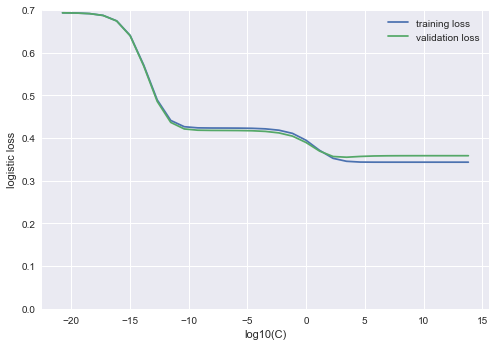

In [97]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0, 0.7]);
plt.plot(np.log(C_grid), tr_loss_list, label = "training loss")
plt.plot(np.log(C_grid), va_loss_list, label = "validation loss")

# TODO add legend
plt.legend();

print("Best C-value for LR with 2-feature data: %.3f" % c_vals[1]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_loss_list))

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

/Users/mattiadanese/opt/anaconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mattiadanese/opt/anaconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/mattiadanese/opt/anaconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level f

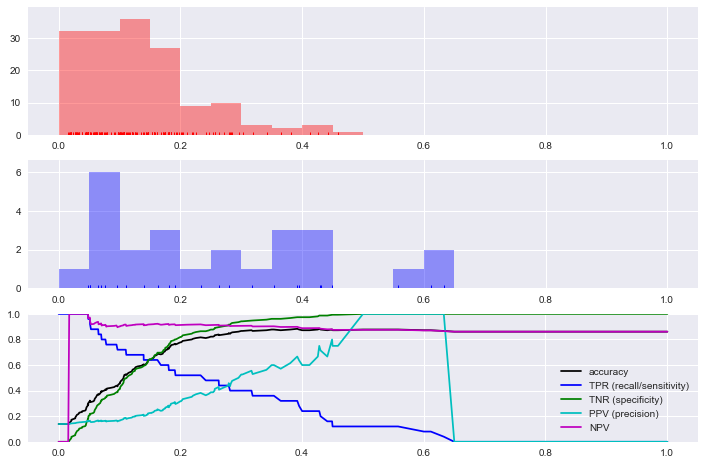

In [98]:
# TODO call make_plot_perf_vs_threshold(...)
best_2F = sklearn.linear_model.LogisticRegression(C=c_vals[1], solver='liblinear')
best_2F.fit(x_tr_M2, y_tr_M)
best_2F_predict_va = best_2F.predict_proba(x_va_N2)


make_plot_perf_vs_threshold(y_va_N, best_2F_predict_va[:,1])


#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [99]:
# TODO like 1.4 (a), but with 3 features
# TODO call make_plot_perf_vs_threshold(...)
C_grid = np.logspace(-9, 6, 31)

tr_loss_list = []
va_loss_list = []

for i in C_grid:
    model = sklearn.linear_model.LogisticRegression(C=i, solver='liblinear')
    model.fit(x_tr_M3, y_tr_M)
    
    predict_tr_3 = model.predict_proba(x_tr_M3)
    predict_va_3 = model.predict_proba(x_va_N3)
    
    tr_loss_list.append(sklearn.metrics.log_loss(y_tr_M, predict_tr_3[:, 1]))
    va_loss_list.append(sklearn.metrics.log_loss(y_va_N, predict_va_3[:, 1]))
    
c_vals = C_grid[tr_loss_list.index(min(tr_loss_list))], C_grid[va_loss_list.index(min(va_loss_list))]
print(c_vals)


(1000000.0, 1000000.0)


#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

Best C-value for LR with 3-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2810


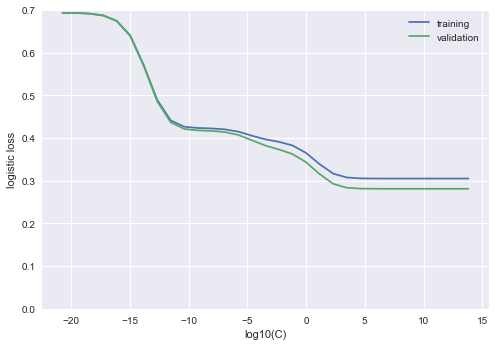

In [100]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);
plt.plot(np.log(C_grid), tr_loss_list, label = "training")
plt.plot(np.log(C_grid), va_loss_list, label = "validation")

# TODO add legend
plt.legend();

print("Best C-value for LR with 3-feature data: %.3f" % c_vals[1]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_loss_list))

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

/Users/mattiadanese/opt/anaconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mattiadanese/opt/anaconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/mattiadanese/opt/anaconda3/envs/ml135_env_sp21/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level f

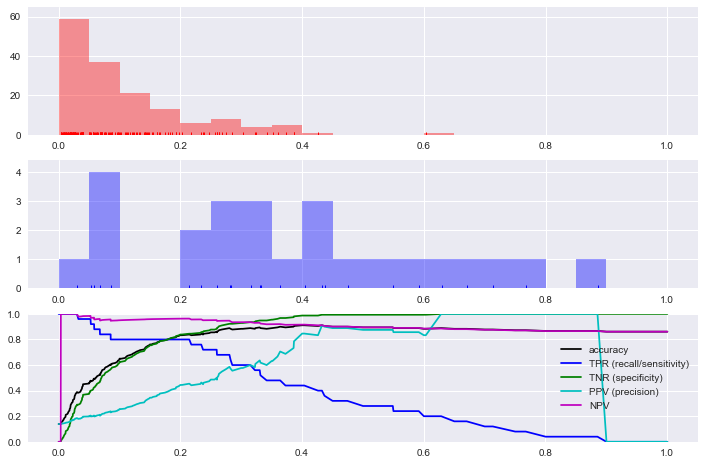

In [101]:
best_3F = sklearn.linear_model.LogisticRegression(C=c_vals[1], solver='liblinear')
best_3F.fit(x_tr_M3, y_tr_M)
best_3F_predict_va = best_3F.predict_proba(x_va_N3)


make_plot_perf_vs_threshold(y_va_N, best_3F_predict_va[:,1])

### 5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

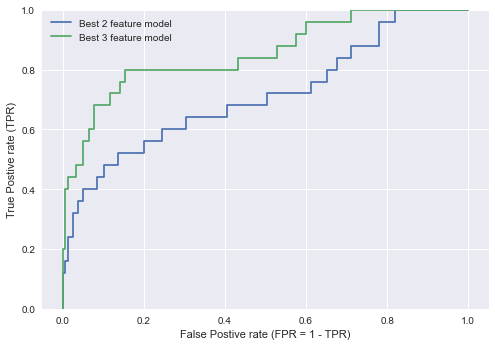

In [102]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y_va_N, best_2F_predict_va[:,1])
fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_va_N, best_3F_predict_va[:,1])

plt.plot(fpr2, tpr2, label = "Best 2 feature model")
plt.plot(fpr3, tpr3, label = "Best 3 feature model")
plt.legend()

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

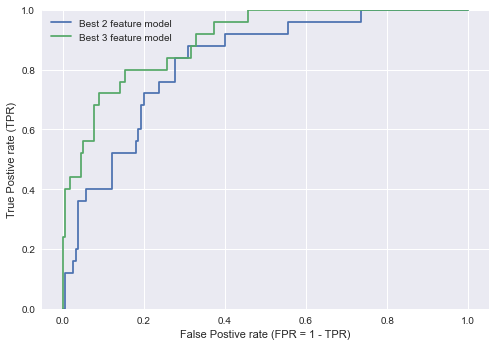

In [103]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

best_2F_predict_te = best_2F.predict_proba(x_te_N2)
best_3F_predict_te = best_3F.predict_proba(x_te_N3)

fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y_te_N, best_2F_predict_te[:,1])
fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_te_N, best_3F_predict_te[:,1])

plt.plot(fpr2, tpr2, label = "Best 2 feature model")
plt.plot(fpr3, tpr3, label = "Best 3 feature model")
plt.legend()

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: The 3-feature model is better than the 2-feature model because it has more area under its ROC curve, for both the validation data and the test data, than that of the 2-feature model. Having more area under its ROC curve means that the 3-feature model has a higher ratio of true postives to false positves, mkaing it better and more desirable than the 2-feature model.

### 6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [104]:
best_thr = 0.5

print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N, best_3F_predict_te[:, 1], best_thr))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, best_3F_predict_te[:, 1], best_thr))

Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV
None


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [105]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, best_3F_predict_va[:, 1])


# TODO Find threshold that makes validation set TPR as large as possible, 
# while satisfying PPV >= 0.98

tpr = 0
for i in range(len(thresh_grid)):
    if perf_grid["tpr"][i] > tpr:
        if perf_grid["ppv"][i] >= 0.98:
            best_thr = thresh_grid[i]
            tpr = perf_grid["tpr"][i]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")

# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N, best_3F_predict_te[:, 1], best_thr))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, best_3F_predict_te[:, 1], best_thr))


ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV
None


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [106]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, best_3F_predict_va[:, 1])

# TODO Find threshold that makes validation set PPV as large as possible, 
# while satisfying TPR >= 0.98

ppv = 0
for i in range(len(thresh_grid)):
    if perf_grid["ppv"][i] > ppv:
        if perf_grid["tpr"][i] >= 0.98:
            best_thr = thresh_grid[i]
            ppv = perf_grid["ppv"][i]


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr) # TODO
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N, best_3F_predict_te[:, 1], best_thr))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, best_3F_predict_te[:, 1], best_thr))

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV
None


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: Soley based on accuracy of the three confusion matrices, the 0.03 threshold is the worst as its accuracy is 0.456 while that of the 0.5 threshold is 0.9 and that of the 0.629 threshold is 0.889. The rest of the values in the confusion matrices of the 0.5 threshold and 0.629 threshold are very similar, however the 0.5 threshlod has a greater True Negative Rate (TNR) than that of the 0.629 threshold. A false negative, in this case, is the worst type of error, as you don't want to tell a patient they don't have cancer when they actually do, so having a greater True Negative Rate makes the 0.629 threshold a slightly better metric than the 0.5 threshold, and ultimately the best threshold out of the three. 

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: Using the classifier with the best threshold (0.629) will avoid doing 175 biopsies. Hoewever, 20 of those 175 should not be avoided as those patients were predicted to not have cancer when they actually do. Therefore, 155 biopsies that should be avoided will in fact be avoided which is about 86% of total biopsies. This is also complementary to the about 14% of patients who actually have cancer across the three data sets (found in problem 2)